In [59]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json

from io import BytesIO
import glob

import torch
import msgpack

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

import networkx

# from tqdm.auto import tqdm
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
DATASET = 'environmental'

ROOT = '../dataset/'
DATA_PATH = f'data/{DATASET}/data.json'

WEIGHT_DIR = 'weight/021/environmental/clip_vision/'

BATCH_SIZE = 1024

NUM_MODELS = 16

NUM_FEATURES = 512

LR = 1e-3

In [54]:
# MINIO_ADDRESS = "123.176.98.90:9000"
MINIO_ADDRESS = "192.168.3.5:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"
bucket_name = 'datasets'

In [53]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.ensemble.ensemble_helpers import Binning, SigmaScoresWithEntropy
from utility.minio.cmd import connect_to_minio_client

# load emb

In [3]:
js = json.load(open(DATA_PATH))

file_paths = list()
image_embeds = list()

for info in tqdm(js.values(), total=len(js), leave=False):

    file_path = os.path.splitext(info['file_path'].split('_')[0])[0]
    
    path = os.path.join(ROOT, 'clip', f'{file_path}_clip.msgpack')

    with open(path, 'rb') as f:
        mp = msgpack.load(f)

    file_paths.append(file_path)
    image_embeds.append(np.array(mp['clip-feature-vector']))

file_paths = np.array(file_paths)
image_embeds = np.concatenate(image_embeds, axis=0)

path_to_index = {file_path: i for i, file_path in enumerate(file_paths)}

# load rank data

In [4]:
paths = sorted(glob.glob(os.path.join(ROOT, 'ranking', DATASET, '*.json')))

rank_pairs = list()

for path in tqdm(paths):
    js = json.load(open(path))

    if js['task'] != 'selection':
        continue
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

100%|██████████| 99313/99313 [00:04<00:00, 21198.53it/s]


# build rank network

In [5]:
graph = networkx.DiGraph()

In [6]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)
len(graph.nodes), len(graph.edges)

(75318, 97620)

## check conflicts

In [7]:
cycles = list(networkx.simple_cycles(graph))
len(cycles)

173

## split samples

In [8]:
subgraphs = list(networkx.weakly_connected_components(graph))
len(subgraphs)

7664

In [9]:
subgraph = graph.subgraph(subgraphs[0])
len(subgraph.nodes), len(subgraph.edges)

(56152, 86114)

In [10]:
from metis import part_graph

In [11]:
(edgecuts, parts) = part_graph(subgraph, NUM_MODELS, ncuts=1, niter=10)

In [12]:
nodes = np.array(list(subgraph.nodes.keys()))
parts = np.array(parts)

split_nodes = list()
split_edges = list()

for i in range(NUM_MODELS):

    nodes_i = set(nodes[parts == i])

    edges_i = list()
    for node_0, node_1 in subgraph.edges.keys():
        if node_0 not in nodes_i or node_1 not in nodes_i:
            continue
        edges_i.append((node_0, node_1))

    split_nodes.append(nodes_i)
    split_edges.append(edges_i)

In [13]:
np.mean(list(map(len, split_edges)))

1947.0

# build dataset

In [14]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

In [15]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [16]:
split_edges = list()
for nodes_i in split_nodes:
    edges_i = ordered_pairs.query('image_1 in @nodes_i and image_2 in @nodes_i')
    split_edges.append(edges_i)

## build feature

In [17]:
val_indices = ordered_pairs.index.difference(sum([list(i.index) for i in split_edges], start=[]))

In [18]:
train_datas = list()
for edges_i in split_edges:
    train_data = list()
    for image_1, image_2 in edges_i.itertuples(index=False, name=None):
        index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
        train_data.append(np.stack([image_embeds[index_1], image_embeds[index_2]], axis=-1))
    train_datas.append(np.stack(train_data, axis=0))

val_data = list()
for image_1, image_2 in ordered_pairs.loc[val_indices].itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    val_data.append(np.stack([image_embeds[index_1], image_embeds[index_2]], axis=-1))
val_data = np.stack(val_data, axis=0)

In [19]:
val_dataset = torch.tensor(val_data).half()#.cuda()

# build model

In [27]:
def train_model(model, train_data, feature_selection=None):
    
    if feature_selection is not None:
        train_data = train_data[..., feature_selection, :]
    train_dataset = torch.tensor(train_data).half().cuda()
    
    model = model.cuda()
    
    parameters = list(model.parameters())

    optimizer = torch.optim.Adam(parameters, lr=LR, weight_decay=1e-3)
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(1000), leave=False):

        bces, accs = list(), list()

        model.train()

        label = torch.zeros((train_dataset.shape[0],), device='cuda')

        x = train_dataset

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(True):

            y0 = model(x[..., 0])
            y1 = model(x[..., 1])

            y = torch.concat([y0, y1], dim=-1)

        # backward

        bce = torch.nn.functional.cross_entropy(y, label.long())

        acc = (y0 > y1).float().mean()

        l1 = torch.norm(model.weight, p=1)

        loss = bce + l1 * 1e-2

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())

    model.eval()

    val_bces, val_accs = list(), list()

    with torch.no_grad():

        with torch.cuda.amp.autocast(True):

            for i in range(0, val_dataset.shape[0], BATCH_SIZE):

                x = val_dataset[i:i+BATCH_SIZE].cuda()
                if feature_selection is not None:
                    x = x[..., feature_selection, :]

                y0 = model(x[..., 0])
                y1 = model(x[..., 1])

                y = torch.concat([y0, y1], dim=-1)

                label = torch.zeros((y.shape[0],), device='cuda').long()

                bce = torch.nn.functional.cross_entropy(y, label)

                acc = (y.argmax(dim=-1) == 0).float().mean()

                val_bces.append(bce.detach().cpu().numpy())
                val_accs.append(acc.detach().cpu().numpy())
    
    print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')

In [21]:
def inference(models, data, feature_selections=None):
    
    results = list()
    
    for model, feature_selection in zip(models, feature_selections):
        
        model.cuda()
        model.eval()

        ys = list()

        with torch.no_grad():

            with torch.cuda.amp.autocast(True):

                for i in range(0, data.shape[0], BATCH_SIZE):

                    x = data[i:i+BATCH_SIZE].cuda()
                    if feature_selection is not None:
                        x = x[..., feature_selection]

                    y = model(x)

                    ys.append(y.detach().cpu().numpy())
        
        ys = np.concatenate(ys, axis=0)
        results.append(ys)
        
    results = np.concatenate(results, axis=-1)
    
    return results

# train model

In [30]:
models = list()
feature_selections = list()

for i, train_data in enumerate(train_datas):
    
    print(i)
    
    if NUM_FEATURES > 0:
        n_features = NUM_FEATURES
        feature_selection = np.array(sorted(np.random.choice(val_data.shape[1], NUM_FEATURES, False)))
    else:
        n_features = val_data.shape[1]
        feature_selection = None
        
    model = torch.nn.Linear(n_features, 1, bias=True)
    
    model = model.cuda()
    
    train_model(model, train_data, feature_selection)
    
    model = model.cpu()
    
    models.append(model)
    feature_selections.append(feature_selection)

0


0.3115 0.8698 0.2868 0.8842
1


0.3069 0.8758 0.2839 0.8820
2


0.3103 0.8774 0.2835 0.8839
3


0.2681 0.9001 0.2848 0.8813
4


0.2932 0.8836 0.2957 0.8802
5


0.2651 0.9007 0.2872 0.8811
6


0.2842 0.8865 0.2894 0.8810
7


0.2693 0.8901 0.2806 0.8842
8


0.2810 0.8860 0.2807 0.8845
9


0.2861 0.8863 0.2947 0.8808
10


0.3071 0.8723 0.2873 0.8810
11


0.2808 0.8880 0.2804 0.8856
12


0.3069 0.8799 0.2829 0.8835
13


0.2959 0.8802 0.2883 0.8815
14


0.3074 0.8745 0.2884 0.8844
15


0.2908 0.8716 0.2860 0.8828


## score distribution

In [44]:
score = inference(models, torch.tensor(image_embeds).half(), feature_selections).astype('float32')
score_mean, score_std = score.mean(axis=0), score.std(axis=0)

In [45]:
sigma_score = (score - score_mean[None, :]) / score_std[None, :]

In [35]:
sigma_score_mean, sigma_score_var = sigma_score.mean(axis=-1), sigma_score.var(axis=-1)
sigma_score_max, sigma_score_min = sigma_score.max(axis=-1), sigma_score.min(axis=-1)

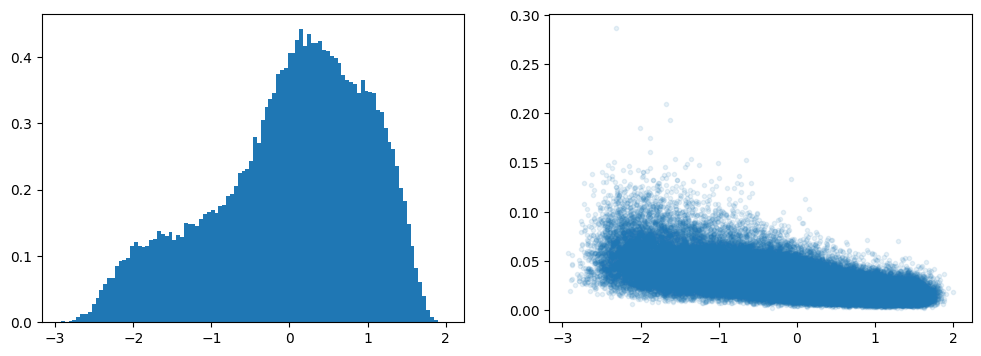

In [38]:
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

_ = pyplot.hist(sigma_score_mean, bins=100, density=True)

pyplot.subplot(1, 2, 2)

pyplot.plot(sigma_score_mean, sigma_score_var, '.', alpha=0.1)

# save model

In [42]:
os.makedirs(WEIGHT_DIR, exist_ok=True)

In [43]:
for i, (model, feature_selection, mean, std) in enumerate(zip(models, feature_selections, score_mean, score_std)):
    torch.save(model.state_dict(), os.path.join(WEIGHT_DIR, f'{i}.pt'))
    np.savez(
        os.path.join(WEIGHT_DIR, f'{i}.npy'), 
        feature_selection=np.array(feature_selection),
        mean=mean,
        std=std,
    )

# analysis

## val set distribution

In [31]:
x = val_dataset

val_y0 = inference(models, x[..., 0], feature_selections).astype('float32')
val_y1 = inference(models, x[..., 1], feature_selections).astype('float32')

val_mean, val_std = val_y0.mean(axis=0, keepdims=True), val_y0.std(axis=0, keepdims=True)
val_y0 = (val_y0 - val_mean) / val_std
val_y1 = (val_y1 - val_mean) / val_std

val_delta = val_y0.mean(axis=-1) - val_y1.mean(axis=-1)

accuracy 0.8897249070631971


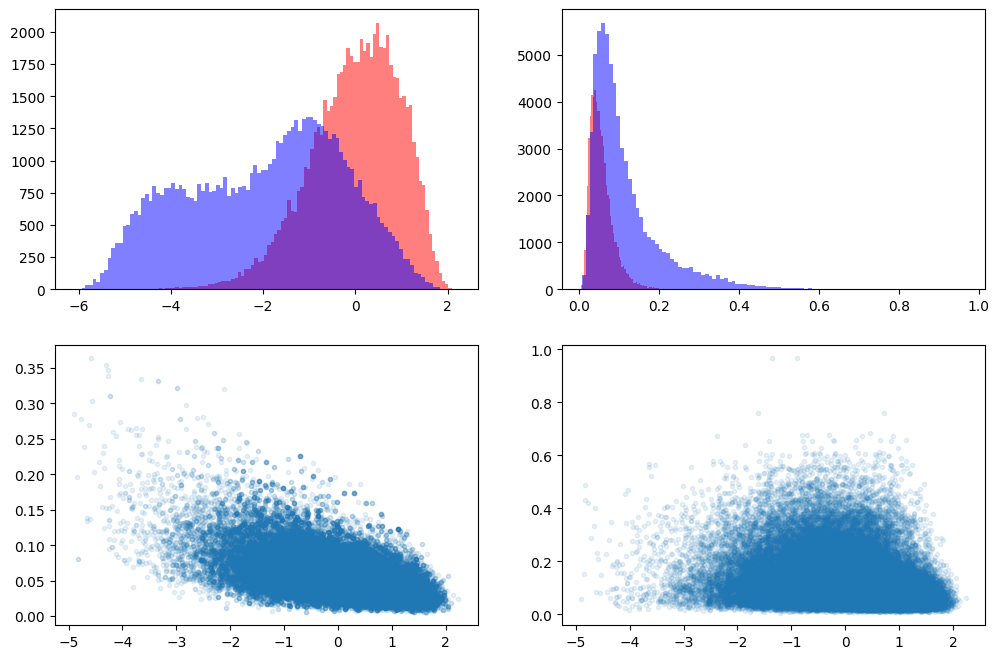

In [32]:
y0, y1, delta = val_y0.mean(axis=-1), val_y1.mean(axis=-1), val_delta
var0, var1, vard = val_y0.var(axis=-1), val_y1.var(axis=-1), (val_y0 - val_y1).var(axis=-1)

print('accuracy', (y0 > y1).mean())

pyplot.figure(figsize=(12, 8))

pyplot.subplot(2, 2, 1)

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)
# _ = pyplot.hist(delta, bins=100, color='y', alpha=0.5)

pyplot.subplot(2, 2, 2)

_ = pyplot.hist(var0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(var1, bins=100, color='b', alpha=0.5)

pyplot.subplot(2, 2, 3)

pyplot.plot(y0, var0, '.', alpha=0.1)

pyplot.subplot(2, 2, 4)

pyplot.plot(y0, var1, '.', alpha=0.1)
# pyplot.plot(var1, delta, '.', alpha=0.1)

# entropy

In [47]:
binning = Binning(start=-2, count=8, step=0.5)
binning.thresholds

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

In [48]:
sigma_scores = SigmaScoresWithEntropy(sigma_scores=sigma_score, binning=binning)

In [50]:
stats = sigma_scores.to_dataframe()
# stats.index = data['file_hashs']

Text(0.5, 0.98, 'environmental 8 bins, 16 linear clip models')

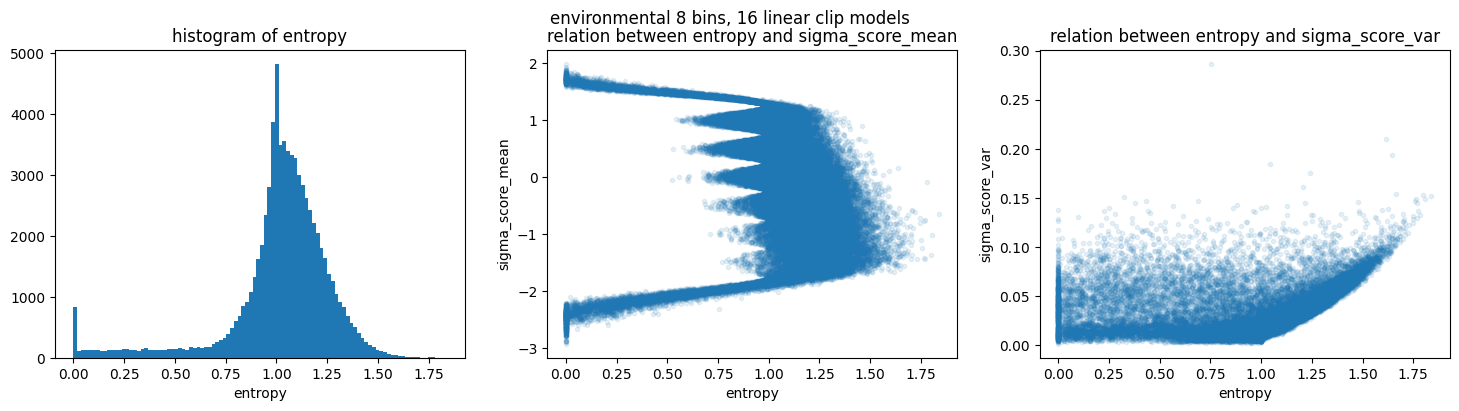

In [63]:
figure = pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)

pyplot.hist(stats['entropy'], bins=100)
pyplot.xlabel('entropy')
pyplot.title('histogram of entropy')

pyplot.subplot(1, 3, 2)

pyplot.plot(stats['entropy'], stats['sigma_score_mean'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_mean')
pyplot.title('relation between entropy and sigma_score_mean')

pyplot.subplot(1, 3, 3)

pyplot.plot(stats['entropy'], stats['sigma_score_var'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_var')
pyplot.title('relation between entropy and sigma_score_var')

figure.suptitle(f'{DATASET} {len(binning.thresholds)} bins, {NUM_MODELS} linear clip models')

# check

In [55]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [57]:
def get_image_by_path(file_path):
    
    data = client.get_object(bucket_name=bucket_name, object_name=f'{file_path}.jpg')

    return Image.open(BytesIO(data.data))

def show_images(file_paths):

    num_rows = max(1, int(np.floor(len(file_paths) ** 0.5)))
    file_paths = file_paths[:num_rows * num_rows]

    target_size = 1024 // num_rows

    images = list()
    for file_path in tqdm(file_paths, leave=False):
        img = get_image_by_path(file_path)
        images.append(np.array(img.resize((target_size, target_size))))

    images = np.stack(images)
    images = images.reshape(num_rows, num_rows, target_size, target_size, 3)
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    return Image.fromarray(images)

In [67]:
selected = stats.query('entropy > 1.25 and sigma_score_mean > 1.')
selected

,sigma_score_mean,sigma_score_var,sigma_score_max,sigma_score_min,entropy,n_models,num_below_start,num_above_end,bin_start,bin_count,bin_step,p
27456,1.008488,0.039973,1.346310,0.639179,1.297850,0,0,0,-2,8,0.5,0;0;0;0;0;2.726;10.28;2.997
40055,1.050046,0.036408,1.374537,0.704923,1.257414,0,0,0,-2,8,0.5,0;0;0;0;0;1.976;10.45;3.577
41731,1.044693,0.044176,1.406511,0.696783,1.306415,0,0,0,-2,8,0.5,0;0;0;0;0;2.251;10.07;3.682
47685,1.144127,0.056919,1.549353,0.686361,1.329157,0,0,2,-2,8,0.5,0;0;0;0;0;1.466;8.568;5.966
50380,1.043054,0.042397,1.339667,0.606375,1.270900,0,0,0,-2,8,0.5,0;0;0;0;0;2.121;10.38;3.498
50885,1.054690,0.035435,1.305514,0.736956,1.289494,0,0,0,-2,8,0.5,0;0;0;0;0;2.052;10.14;3.803
51054,1.028673,0.035997,1.370593,0.710756,1.282081,0,0,0,-2,8,0.5,0;0;0;0;0;2.361;10.36;3.279
51501,1.083583,0.036802,1.429451,0.711349,1.251369,0,0,0,-2,8,0.5,0;0;0;0;0;1.57;10.18;4.245
52791,1.139590,0.042046,1.403416,0.807290,1.264486,0,0,0,-2,8,0.5,0;0;0;0;0;1.165;9.202;5.632
53401,1.037389,0.039924,1.452373,0.733697,1.260804,0,0,0,-2,8,0.5,0;0;0;0;0;2.154;10.5;3.35


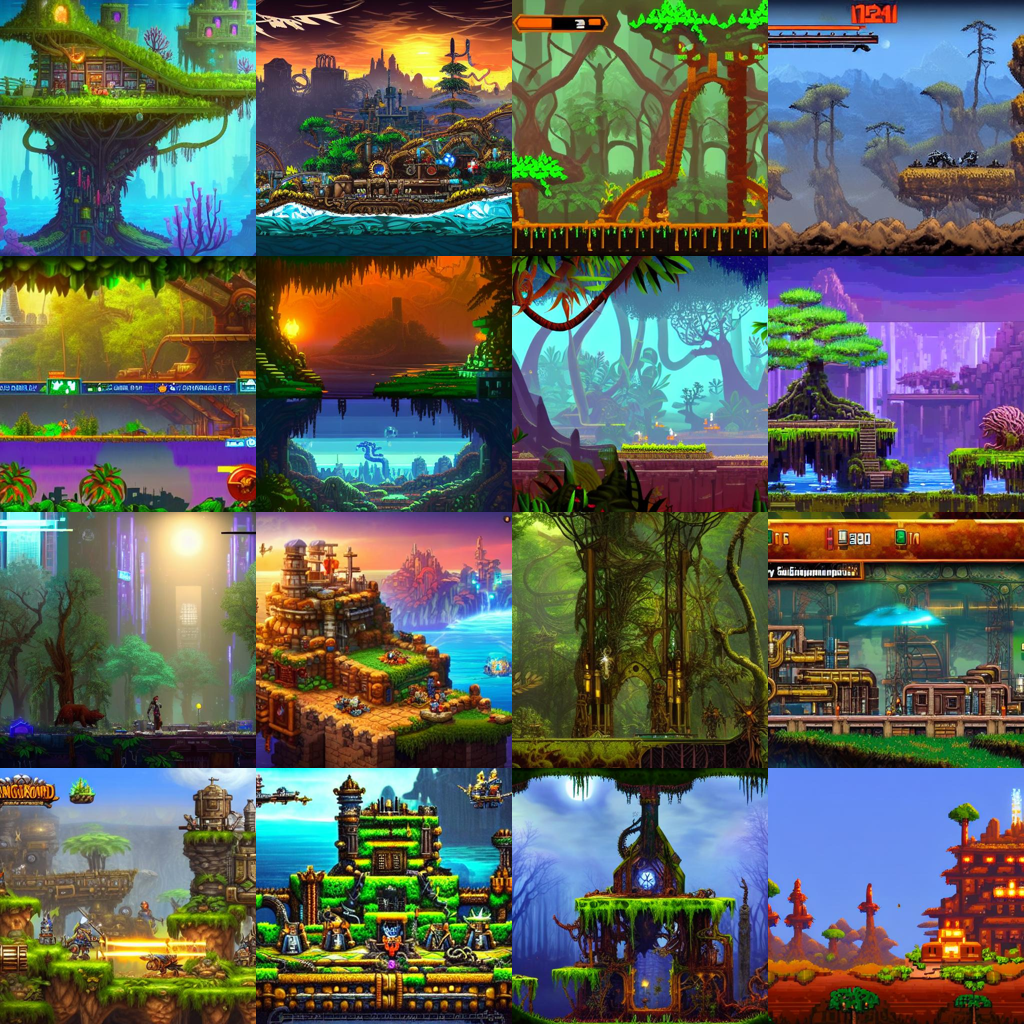

In [68]:
show_images(file_paths[selected.index[-16:]])